<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/2.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,4.011808
1,4.016080
2,3.993376
3,3.981656
4,3.996736
...,...
38875,7.981184
38876,7.982088
38877,7.980072
38878,7.974312


In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
#         seasonal_init,trend_init = seasonal_init.cpu(), trend_init.cpu() 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_497082/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [12]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.5000e-06.
smape 12.66967592338149 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 7.963444245693258 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 7.674591609457922 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 7.387424352162173 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 6.859685497859504 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 6.660104434425283 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 6.531878441765534 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 6.349669734658728 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 6.122969659508277 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 5.938636651303488 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 5.794097078604656 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 5.631302347296456 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 5.4467904450622395 %
Adjusting l

In [13]:
torch.manual_seed(42)

In [14]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [15]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model2.pt') 
# 모델의 갱신의 loss가 현재 알고있는 값과 그 이전의 값으로 갱신이 되는데 이게 새로운 모델의 예측에선 안맞을 수 있다
# 기존 2%대 성능에서 0.3% 로 성능 개선 
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
    #model = torch.load(PATH+'/best_model2.pt') 
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 1.6792186591774223 %
SMAPE 0.0852212573779525 %
SMAPE 0.618709325324744 %
SMAPE 0.12437951303081718 %
SMAPE 0.24172750568675383 %
SMAPE 0.9009946440346538 %
SMAPE 0.5274437807966024 %
SMAPE 0.09619205992885327 %
SMAPE 0.8268149183131756 %
SMAPE 0.0905202248814021 %
SMAPE 0.7162449604365975 %
SMAPE 0.7343232263810933 %
SMAPE 0.4246642606885871 %
SMAPE 0.12204345238302494 %
SMAPE 0.9786620428785682 %
SMAPE 1.2629334330558777 %
SMAPE 0.5475405063480139 %
SMAPE 0.3697199593514142 %
SMAPE 0.02671553002963378 %
SMAPE 0.009419520426021677 %
SMAPE 0.115064437971796 %
SMAPE 0.8148548193275928 %
SMAPE 0.0061508041887208265 %
SMAPE 1.1630706624127924 %
SMAPE 0.4465669408091344 %
SMAPE 0.5619740263791755 %
SMAPE 0.5239656631601974 %
SMAPE 0.35493122403113375 %
SMAPE 0.5977767368312925 %
SMAPE 0.03952825381804814 %
SMAPE 0.2732263039160898 %
SMAPE 0.03309689034870189 %
SMAPE 0.055191456086731705 %
SMAPE 0.327827843670093 %
SMAPE 0.5503390891244635 %
SMAPE 0.014516042326135905 %
SMAPE 0.047708

SMAPE 0.004757601099385056 %
SMAPE 0.008574494802431332 %
SMAPE 0.0033093319859318626 %
SMAPE 0.00881544930361855 %
SMAPE 0.02413266439924655 %
SMAPE 0.28033051598481507 %
SMAPE 0.00128839299500072 %
SMAPE 0.06793420397912087 %
SMAPE 0.014132200570941222 %
SMAPE 0.011068373759307804 %
SMAPE 0.013823849926126286 %
SMAPE 0.009568305375978525 %
SMAPE 0.006713411223678634 %
SMAPE 0.02677226805445798 %
SMAPE 0.035827858638810994 %
SMAPE 0.05954895691689899 %
SMAPE 0.033593474437680015 %
SMAPE 0.017970313864168475 %
SMAPE 0.02082277388581133 %
SMAPE 0.0373157371861339 %
SMAPE 0.015692293328726237 %
SMAPE 0.0049808574600831435 %
SMAPE 0.0021891316870181754 %
SMAPE 0.019534597019287503 %
SMAPE 0.01907834461833602 %
SMAPE 0.04643697226970289 %
SMAPE 0.023087752543609952 %
SMAPE 0.0338266838325012 %
SMAPE 0.020500538098367826 %
SMAPE 0.03271702335973714 %
SMAPE 0.028522162128581385 %
SMAPE 0.04383513060815858 %
SMAPE 0.021208337813106937 %
SMAPE 0.0023025087721251225 %
SMAPE 0.03483476853523371 

SMAPE 0.0846414907534978 %
SMAPE 0.06897551656686574 %
SMAPE 0.04835492046831291 %
SMAPE 0.038648902274047714 %
SMAPE 0.025087264172952928 %
SMAPE 0.06074556668681908 %
SMAPE 0.07784163763301422 %
SMAPE 0.003063335084398488 %
SMAPE 0.01809792380095132 %
SMAPE 0.12736245424497383 %
SMAPE 0.15397649780527445 %
SMAPE 0.07594187382289874 %
SMAPE 0.09904104471934261 %
SMAPE 0.11428743681517516 %
SMAPE 0.07237817510070954 %
SMAPE 0.23645637854951929 %
SMAPE 0.37660382989633945 %
SMAPE 0.050136842987683394 %
SMAPE 0.00962043844593552 %
SMAPE 0.13897537180395148 %
SMAPE 0.10554864322740798 %
SMAPE 0.008537401717461535 %
SMAPE 0.05703512628397789 %
SMAPE 0.11126511494614988 %
SMAPE 0.014733283396680006 %
SMAPE 0.0742452608626536 %
SMAPE 0.16346241257787142 %
SMAPE 0.0019439925337962904 %
SMAPE 0.0018524579872405411 %
SMAPE 0.054781941201781585 %
SMAPE 0.048634280629130444 %
SMAPE 0.03915481293239509 %
SMAPE 0.08992256467644211 %
SMAPE 0.12966143703965827 %
SMAPE 0.04726152614205148 %
SMAPE 0.10

SMAPE 0.02523122210288875 %
SMAPE 0.015833108676872598 %
SMAPE 0.024345336248345006 %
SMAPE 0.003974562184339447 %
SMAPE 0.026513268980238536 %
SMAPE 0.007955573046508846 %
SMAPE 0.010041525267908469 %
SMAPE 0.03435941942552745 %
SMAPE 0.11490695900431547 %
SMAPE 0.006915916028560787 %
SMAPE 0.010651283592927996 %
SMAPE 0.02731081414322034 %
SMAPE 0.09767423554034593 %
SMAPE 0.16427713952452905 %
SMAPE 0.18911760154514923 %
SMAPE 0.027036928833652496 %
SMAPE 0.06149490571846172 %
SMAPE 0.0019386236369882681 %
SMAPE 0.033207314230821794 %
SMAPE 0.06028576178914591 %
SMAPE 0.10582394328322664 %
SMAPE 0.03834391414056881 %
SMAPE 0.03429564060476764 %
SMAPE 0.007015241672490902 %
SMAPE 0.05897703021648937 %
SMAPE 0.02658711162921179 %
SMAPE 0.03490765322635525 %
SMAPE 0.023096196680924663 %
SMAPE 0.03277219515569385 %
SMAPE 0.0024083962823056027 %
SMAPE 0.010735070803846725 %
SMAPE 0.004401593705495088 %
SMAPE 0.01508409821586554 %
SMAPE 0.08113462744904609 %
SMAPE 0.0018417490409774473 %


SMAPE 0.010270428070498383 %
SMAPE 0.006548777006976536 %
SMAPE 0.08696373924703948 %
SMAPE 0.08157655782042639 %
SMAPE 0.0017295687871410337 %
SMAPE 0.03770203988034382 %
SMAPE 0.2764774718953049 %
SMAPE 0.08534713793712001 %
SMAPE 0.007900833850669642 %
SMAPE 0.08513851716978138 %
SMAPE 0.038329816210421086 %
SMAPE 0.04250759246971825 %
SMAPE 0.09328660555183887 %
SMAPE 0.09623166564449548 %
SMAPE 0.004554102369695556 %
SMAPE 0.030748772542537495 %
SMAPE 0.1669544193064212 %
SMAPE 0.1416501009397848 %
SMAPE 0.04373523710455629 %
SMAPE 0.005526814866755103 %
SMAPE 0.001023784641326131 %
SMAPE 0.05343718355698002 %
SMAPE 0.010817597259588752 %
SMAPE 0.010710711532027517 %
SMAPE 0.014115361543076688 %
SMAPE 0.003010086633253195 %
SMAPE 0.14601796297756664 %
SMAPE 0.1588649499260555 %
SMAPE 0.01984851850869518 %
SMAPE 0.011363077780970343 %
SMAPE 0.0091795791934004 %
SMAPE 0.012796914401008053 %
SMAPE 0.021824123213946223 %
SMAPE 0.04876332725228849 %
SMAPE 0.005209826353848257 %
SMAPE 0

SMAPE 0.006584289861379489 %
SMAPE 0.019593086201872723 %
SMAPE 0.04923975770975631 %
SMAPE 0.04115280205598992 %
SMAPE 0.08435069935148931 %
SMAPE 0.003050486634720073 %
SMAPE 0.030058986529894582 %
SMAPE 0.17100594520070445 %
SMAPE 0.1451770031234645 %
SMAPE 0.03741509135943488 %
SMAPE 0.03714085816181978 %
SMAPE 0.036729187562599463 %
SMAPE 0.0419544004519139 %
SMAPE 0.038390358305832706 %
SMAPE 0.033675039836438714 %
SMAPE 0.0026522508614164053 %
SMAPE 0.014873160918114081 %
SMAPE 0.09893451901047001 %
SMAPE 0.09366820565901435 %
SMAPE 0.03649386772440266 %
SMAPE 0.0054846569356072905 %
SMAPE 0.013283770437510611 %
SMAPE 0.012972400129100945 %
SMAPE 0.010043673081248983 %
SMAPE 0.013222606174622342 %
SMAPE 0.002389324369175938 %
SMAPE 0.010429849708998518 %
SMAPE 0.055732239832195773 %
SMAPE 0.10406412662996446 %
SMAPE 0.010498000425968712 %
SMAPE 0.02960208866525704 %
SMAPE 0.0034658671921761197 %
SMAPE 0.007976053934612537 %
SMAPE 0.0006515820858510324 %
SMAPE 0.00182966259762906

SMAPE 0.0359248399788612 %
SMAPE 0.10725383597855398 %
SMAPE 0.026564137702621338 %
SMAPE 0.024460300564840057 %
SMAPE 0.031740283648588274 %
SMAPE 0.04788129866443569 %
SMAPE 0.03377415914900439 %
SMAPE 0.04461017249593624 %
SMAPE 0.0014026805845333001 %
SMAPE 0.0008447080696782905 %
SMAPE 0.11241393488649011 %
SMAPE 0.08392020556689772 %
SMAPE 0.01996416311422422 %
SMAPE 0.011457135874650248 %
SMAPE 0.0009574396273706043 %
SMAPE 0.01081052889502132 %
SMAPE 0.0052475562266565134 %
SMAPE 0.039850521015182494 %
SMAPE 0.009028110854842453 %
SMAPE 0.04509825549894231 %
SMAPE 0.047253180075699674 %
SMAPE 0.04837334326495579 %
SMAPE 0.0026534266204407686 %
SMAPE 0.0016999700074649129 %
SMAPE 0.003609998798538072 %
SMAPE 0.002200310621560675 %
SMAPE 0.011067430608079576 %
SMAPE 0.03078709553733461 %
SMAPE 0.023910596931941086 %
SMAPE 0.04072561781316608 %
SMAPE 0.07241400558928035 %
SMAPE 0.09699964394803828 %
SMAPE 0.01565359844687464 %
SMAPE 0.0006929647434077424 %
SMAPE 0.0076360231771985

SMAPE 0.0021362114931093856 %
SMAPE 0.020692081534832596 %
SMAPE 0.12523775923517633 %
SMAPE 0.04873597024538867 %
SMAPE 0.016105000358578536 %
SMAPE 0.009021798404774017 %
SMAPE 0.004982447326391082 %
SMAPE 0.014212699679461593 %
SMAPE 0.0014038165268033254 %
SMAPE 0.010007753333667324 %
SMAPE 0.03543643276111652 %
SMAPE 0.0210163731189823 %
SMAPE 0.0237607139685565 %
SMAPE 0.024340835617124412 %
SMAPE 0.011481364918481063 %
SMAPE 0.0022830506155742114 %
SMAPE 0.02041008549860379 %
SMAPE 0.000879224133683465 %
SMAPE 0.004736491487221883 %
SMAPE 0.00393869274525116 %
SMAPE 0.01973303483948996 %
SMAPE 0.004823959955331247 %
SMAPE 0.15131094129253597 %
SMAPE 0.1092062636710125 %
SMAPE 0.028254519376403664 %
SMAPE 0.06859548546401584 %
SMAPE 0.05968907945589308 %
SMAPE 0.009744281962689172 %
SMAPE 0.0019156222190304106 %
SMAPE 0.03163925399485379 %
SMAPE 0.006837297459867386 %
SMAPE 0.008010247711808915 %
SMAPE 0.12603896708056084 %
SMAPE 0.047237289187364695 %
SMAPE 0.0026787694980043852

SMAPE 0.040364561364299334 %
SMAPE 0.10605099313113443 %
SMAPE 0.02797463892687802 %
SMAPE 0.003144034852645916 %
SMAPE 0.12141897800870538 %
SMAPE 0.19927353043794938 %
SMAPE 0.06304711552553499 %
SMAPE 0.04482922087612451 %
SMAPE 0.09249338008339691 %
SMAPE 0.11933827626876338 %
SMAPE 0.07254337054951066 %
SMAPE 0.16494074027173156 %
SMAPE 0.0689795035380456 %
SMAPE 0.02258857971452244 %
SMAPE 0.11633090468092178 %
SMAPE 0.20443521551987942 %
SMAPE 0.06208233139966524 %
SMAPE 0.023660946767904534 %
SMAPE 0.03634463528712217 %
SMAPE 0.026880158378503435 %
SMAPE 0.023463785465565934 %
SMAPE 0.04825585838676716 %
SMAPE 0.0019184212155778368 %
SMAPE 0.01222422409566093 %
SMAPE 0.030004169753354404 %
SMAPE 0.08560742890904294 %
SMAPE 0.005860553873972663 %
SMAPE 0.004707779658474465 %
SMAPE 0.03896287770974993 %
SMAPE 0.03859740066558004 %
SMAPE 0.032691621937090076 %
SMAPE 0.13044194573990353 %
SMAPE 0.042567017369719906 %
SMAPE 0.025001074370209157 %
SMAPE 0.20621005611974394 %
SMAPE 0.

SMAPE 0.009725277848673386 %
SMAPE 0.8323453648481518 %
SMAPE 0.12757508277331908 %
SMAPE 0.058065143016278846 %
SMAPE 0.762121785315685 %
SMAPE 0.01053813630642253 %
SMAPE 0.07555964317123198 %
SMAPE 0.03169207692161535 %
SMAPE 0.43824612834214344 %
SMAPE 0.007275604439804795 %
SMAPE 0.0833123208788038 %
SMAPE 1.0678285812027752 %
SMAPE 0.03558704726879114 %
SMAPE 0.006982429126061617 %
SMAPE 0.2482667449962719 %
SMAPE 0.02595666695788168 %
SMAPE 0.136851298042302 %
SMAPE 1.0509445206262171 %
SMAPE 0.4769008670027688 %
SMAPE 0.5787107784781256 %
SMAPE 0.1589889720330575 %
SMAPE 0.2909052030163366 %
SMAPE 1.5630930662155151 %
SMAPE 0.9696791712194681 %
SMAPE 0.2437446877469256 %
SMAPE 1.3317220294848084 %
SMAPE 0.9559924826025962 %
SMAPE 0.22021093607372677 %
SMAPE 0.04538995371706278 %
SMAPE 0.9469493434298784 %
SMAPE 1.4528922475874424 %
SMAPE 1.2781527349725366 %
SMAPE 0.06178646697014756 %
SMAPE 0.4542947967056534 %
SMAPE 1.0007517519406974 %
SMAPE 0.1724301666260999 %
SMAPE 0.2369

SMAPE 0.9136839308775963 %
SMAPE 0.9892037222161889 %
SMAPE 1.117276725359261 %
SMAPE 1.2728428831323981 %
SMAPE 0.09497103980565669 %
SMAPE 0.3608478137912243 %
SMAPE 0.20535122233673064 %
SMAPE 0.17751298672101257 %
SMAPE 0.27841917024124996 %
SMAPE 0.2738685352514949 %
SMAPE 0.7440648910123855 %
SMAPE 1.4163669804111123 %
SMAPE 2.1710760854184628 %
SMAPE 0.8625012785196305 %
SMAPE 0.2393655591322386 %
SMAPE 0.770265709143132 %
SMAPE 0.07032877539500504 %
SMAPE 0.20384932417073287 %
SMAPE 0.048728873656557425 %
SMAPE 0.07618630929914616 %
SMAPE 0.287744387953353 %
SMAPE 0.04972738533248844 %
SMAPE 0.22858223703150315 %
SMAPE 0.003996281621077458 %
SMAPE 0.7012564777396619 %
SMAPE 0.23496605175171223 %
SMAPE 0.35113847961474676 %
SMAPE 0.34541724367591087 %
SMAPE 0.5664318206254393 %
SMAPE 0.022415045669440303 %
SMAPE 0.11316447631526216 %
SMAPE 0.29395513190229394 %
SMAPE 0.4614098201491288 %
SMAPE 0.009291739053423953 %
SMAPE 0.22238477882820007 %
SMAPE 0.4107393235390191 %
SMAPE 1.

SMAPE 0.37081930669228313 %
SMAPE 0.8621167009696364 %
SMAPE 0.6699610815849155 %
SMAPE 0.12404059246819087 %
SMAPE 0.009313872256178968 %
SMAPE 0.4268079978464812 %
SMAPE 0.041991566386229806 %
SMAPE 0.45584148880152503 %
SMAPE 0.0070838368853571865 %
SMAPE 0.12565563129010116 %
SMAPE 0.051043763203821875 %
SMAPE 0.13636120295518595 %
SMAPE 0.0018500436727961758 %
SMAPE 0.025630209073177923 %
SMAPE 0.18051760085973 %
SMAPE 0.19578151969164992 %
SMAPE 0.04179814582244035 %
SMAPE 1.2370876455679536 %
SMAPE 0.3270871662002719 %
SMAPE 0.46499757436686195 %
SMAPE 0.9158650976605713 %
SMAPE 0.3142040911661752 %
SMAPE 0.11086485313808224 %
SMAPE 0.47230168998066807 %
SMAPE 0.22131435435721866 %
SMAPE 0.3351107513826719 %
SMAPE 0.5851858298992738 %
SMAPE 0.3332806037933551 %
SMAPE 0.02733424721327538 %
SMAPE 0.023688111220209862 %
SMAPE 0.23937515052784875 %
SMAPE 0.01500247521404674 %
SMAPE 0.15455326351070653 %
SMAPE 0.541730337892659 %
SMAPE 0.08407959457349534 %
SMAPE 0.49172746783006005 

SMAPE 1.074838986620307 %
SMAPE 0.5127631010254845 %
SMAPE 0.13425229640256475 %
SMAPE 0.031045739860587677 %
SMAPE 0.2712349583143805 %
SMAPE 0.290868027679295 %
SMAPE 0.2515200353864202 %
SMAPE 0.9768268428742886 %
SMAPE 0.26938256085031753 %
SMAPE 0.05015773620948494 %
SMAPE 0.09730478183018931 %
SMAPE 0.21539746273992935 %
SMAPE 0.12108651719302088 %
SMAPE 0.4997701272368431 %
SMAPE 0.013836117100794356 %
SMAPE 0.005009150213822977 %
SMAPE 0.018486981407448866 %
SMAPE 0.3296693769771082 %
SMAPE 0.17491832259020157 %
SMAPE 0.34178925779087876 %
SMAPE 0.7406727217603475 %
SMAPE 0.303352238752268 %
SMAPE 0.34358789395628264 %
SMAPE 0.3060583273118027 %
SMAPE 0.26974567975321406 %
SMAPE 0.018834361786332465 %
SMAPE 0.47188253962667664 %
SMAPE 0.04926879892482816 %
SMAPE 0.3131003923845128 %
SMAPE 0.06616395637819039 %
SMAPE 0.5682391030713916 %
SMAPE 0.19478466376676806 %
SMAPE 0.09699490719776804 %
SMAPE 0.017502158613751817 %
SMAPE 0.5218854494160041 %
SMAPE 0.40094640445386176 %
SMA

SMAPE 0.11093570742590941 %
SMAPE 0.08751128009021159 %
SMAPE 0.6731873771641403 %
SMAPE 0.20136416402192478 %
SMAPE 0.24202225208136952 %
SMAPE 0.15018549069225173 %
SMAPE 0.45114886795636266 %
SMAPE 0.6607034092303365 %
SMAPE 0.5797757029067725 %
SMAPE 0.4420065983431414 %
SMAPE 0.005045339841643681 %
SMAPE 0.07230632740886733 %
SMAPE 0.8173697958700359 %
SMAPE 0.04182400701853339 %
SMAPE 0.14307660953397772 %
SMAPE 0.654951948672533 %
SMAPE 0.5160914483712986 %
SMAPE 0.049862043905498865 %
SMAPE 0.6742183994501829 %
SMAPE 0.08029814196333973 %
SMAPE 0.49037140351720154 %
SMAPE 0.6372067041229457 %
SMAPE 0.19792972240225024 %
SMAPE 0.11762682364519605 %
SMAPE 0.009946045876404241 %
SMAPE 0.43677295785164466 %
SMAPE 0.7223985821474344 %
SMAPE 0.5049385478487238 %
SMAPE 0.5030622959602624 %
SMAPE 1.0668941121548414 %
SMAPE 1.2840336924418807 %
SMAPE 1.0806770455092192 %
SMAPE 0.9361033262684941 %
SMAPE 0.13160122901490467 %
SMAPE 0.06600551753058426 %
SMAPE 0.2984005531425282 %
SMAPE 0

SMAPE 0.06534956984781815 %
SMAPE 0.08008918272106769 %
SMAPE 0.13874407607045214 %
SMAPE 0.2105833504845123 %
SMAPE 0.26612978792763897 %
SMAPE 0.36495680656662444 %
SMAPE 0.11950535723633494 %
SMAPE 0.1670504535916848 %
SMAPE 0.44881496491143474 %
SMAPE 0.40255355671979487 %
SMAPE 0.26505872371717487 %
SMAPE 0.15326295288832625 %
SMAPE 0.20336813618564517 %
SMAPE 0.10406092292416247 %
SMAPE 0.0437123114932092 %
SMAPE 0.25398945016036123 %
SMAPE 0.11985315452966461 %
SMAPE 0.10418611748787042 %
SMAPE 0.2595020494509299 %
SMAPE 0.3601126658722933 %
SMAPE 0.2664662131539899 %
SMAPE 0.03243523309834018 %
SMAPE 0.09126356969392191 %
SMAPE 0.1396188855778746 %
SMAPE 0.07299845457038145 %
SMAPE 0.16661460299428654 %
SMAPE 0.02150318529018591 %
SMAPE 0.0007067492089944949 %
SMAPE 0.16053974035844476 %
SMAPE 0.1991878873236601 %
SMAPE 0.0834265620064798 %
SMAPE 0.09854141627980084 %
SMAPE 0.11868497212026341 %
SMAPE 0.11402067515200542 %
SMAPE 0.23559519731497858 %
SMAPE 0.21858323767082766 %

SMAPE 0.07112693818163507 %
SMAPE 0.07257421470967529 %
SMAPE 0.001974855092157668 %
SMAPE 0.0054830828410104004 %
SMAPE 0.005286109438586095 %
SMAPE 0.017554650796796523 %
SMAPE 0.004426979552420107 %
SMAPE 0.012539515168541016 %
SMAPE 0.00265572957778204 %
SMAPE 0.0019027131888833537 %
SMAPE 0.15903721966441253 %
SMAPE 0.0835668397671725 %
SMAPE 0.02946938178217806 %
SMAPE 0.01053514053413096 %
SMAPE 0.01935901164324605 %
SMAPE 0.05051726337832463 %
SMAPE 0.04795199766521563 %
SMAPE 0.12538706146040113 %
SMAPE 0.010117033372381457 %
SMAPE 0.030129218122056045 %
SMAPE 0.1427155268788738 %
SMAPE 0.09118438536455642 %
SMAPE 0.0327822175117376 %
SMAPE 0.02014088454160401 %
SMAPE 0.03190572342799669 %
SMAPE 0.06085687631806991 %
SMAPE 0.03975460741128245 %
SMAPE 0.06646314651834473 %
SMAPE 0.018489532442771406 %
SMAPE 0.04579177903826803 %
SMAPE 0.153931280667166 %
SMAPE 0.16910720694090742 %
SMAPE 0.10159496588084949 %
SMAPE 0.10533448794012656 %
SMAPE 0.03888930089132714 %
SMAPE 0.06689

SMAPE 0.02247019001976014 %
SMAPE 0.01929461751041117 %
SMAPE 0.01727058117066349 %
SMAPE 0.12412042874211691 %
SMAPE 0.041011915926418396 %
SMAPE 0.0026127748903945758 %
SMAPE 0.00264333123641336 %
SMAPE 0.039517007893550726 %
SMAPE 0.019605651262764923 %
SMAPE 0.009595642506866398 %
SMAPE 0.08665884073269581 %
SMAPE 0.011279341111986696 %
SMAPE 0.10937956616857036 %
SMAPE 0.1693910599906303 %
SMAPE 0.196195052473513 %
SMAPE 0.03353005760285299 %
SMAPE 0.08036826806642239 %
SMAPE 0.13372900197754234 %
SMAPE 0.07577762305146507 %
SMAPE 0.03963312562882493 %
SMAPE 0.0988847086819078 %
SMAPE 0.022216250889869116 %
SMAPE 0.01897971431787937 %
SMAPE 0.19934998122744219 %
SMAPE 0.17325520327813138 %
SMAPE 0.044203362953112446 %
SMAPE 0.02040760814782061 %
SMAPE 0.054144674956916106 %
SMAPE 0.04492163300190555 %
SMAPE 0.07178735420370685 %
SMAPE 0.1192622218827637 %
SMAPE 0.006766284148085333 %
SMAPE 0.005390638337914311 %
SMAPE 0.2139745695229749 %
SMAPE 0.13246291563808654 %
SMAPE 0.017656

SMAPE 0.008157307686076365 %
SMAPE 0.017890218584852846 %
SMAPE 0.022412099349367054 %
SMAPE 0.03692858173968716 %
SMAPE 0.014838883069558053 %
SMAPE 0.0006322816933845843 %
SMAPE 0.005180997063916948 %
SMAPE 0.044812732464549754 %
SMAPE 0.0031162120665158 %
SMAPE 0.024042700243640525 %
SMAPE 0.04098765854882913 %
SMAPE 0.01775047323508261 %
SMAPE 0.028578579387556147 %
SMAPE 0.12525828424395513 %
SMAPE 0.04530094319272848 %
SMAPE 0.013074512552108786 %
SMAPE 0.011784988551909237 %
SMAPE 0.02625434648416558 %
SMAPE 0.03857649219969517 %
SMAPE 0.054812140346200515 %
SMAPE 0.06041465750399767 %
SMAPE 0.0031863977686157345 %
SMAPE 0.00744900412944105 %
SMAPE 0.07948253933727756 %
SMAPE 0.2217480773879288 %
SMAPE 0.03561061349751071 %
SMAPE 0.0051385442465061715 %
SMAPE 0.11586697591691575 %
SMAPE 0.08288968023529719 %
SMAPE 0.021862925737366368 %
SMAPE 0.062467596366559526 %
SMAPE 0.06599497353340666 %
SMAPE 0.1096669640237451 %
SMAPE 0.14905388132729058 %
SMAPE 0.08324210518878772 %
SMAP

SMAPE 0.002163230315773035 %
SMAPE 0.04174996714129975 %
SMAPE 0.0080230678167581 %
SMAPE 0.020297279734080576 %
SMAPE 0.14475339035823254 %
SMAPE 0.1884158064576411 %
SMAPE 0.053064091560827364 %
SMAPE 0.03028594072115709 %
SMAPE 0.046111523348145056 %
SMAPE 0.04454170158044235 %
SMAPE 0.1031088256283965 %
SMAPE 0.06725460527070481 %
SMAPE 0.009081254362513391 %
SMAPE 0.00179310704218949 %
SMAPE 0.05520475421820947 %
SMAPE 0.030734037413935766 %
SMAPE 0.010495324091152725 %
SMAPE 0.02323065737735419 %
SMAPE 0.005618155657487023 %
SMAPE 0.019061634779852454 %
SMAPE 0.008626172707351998 %
SMAPE 0.02572835782962102 %
SMAPE 0.008022909011629054 %
SMAPE 0.013625127326520216 %
SMAPE 0.08066494510137545 %
SMAPE 0.04688994758913623 %
SMAPE 0.028163427995835377 %
SMAPE 0.04523560488613043 %
SMAPE 0.029023179340697425 %
SMAPE 0.008312673269870174 %
SMAPE 0.003742270088537225 %
SMAPE 0.01645736289958677 %
SMAPE 0.04167060298142644 %
SMAPE 0.006432335188932825 %
SMAPE 0.004053002451968268 %
SMAPE

SMAPE 0.021172240447185686 %
SMAPE 0.009802000354284246 %
SMAPE 0.021298727147268437 %
SMAPE 0.01726748203234507 %
SMAPE 0.032064272874052335 %
SMAPE 0.12608945927786408 %
SMAPE 0.005772281017002001 %
SMAPE 0.019654881401947932 %
SMAPE 0.014866417713733426 %
SMAPE 0.04535102963063764 %
SMAPE 0.02025902468923846 %
SMAPE 0.03892768018513948 %
SMAPE 0.033825573273588816 %
SMAPE 0.00264802686206167 %
SMAPE 0.05721399051941489 %
SMAPE 0.06205164872869773 %
SMAPE 0.02524922199917512 %
SMAPE 0.06928490062099968 %
SMAPE 0.0010877669987650052 %
SMAPE 0.020182482333666485 %
SMAPE 0.03767878619567 %
SMAPE 0.009401962073269488 %
SMAPE 0.0023810523491647473 %
SMAPE 0.004553012756716157 %
SMAPE 0.05545817067081771 %
SMAPE 0.001587222384614506 %
SMAPE 0.0759032365392045 %
SMAPE 0.0038306956094515954 %
SMAPE 0.02430736279305279 %
SMAPE 0.03267022960608301 %
SMAPE 0.0380413030623572 %
SMAPE 0.01775142582891931 %
SMAPE 0.01982060874333058 %
SMAPE 0.017049098997915735 %
SMAPE 0.0933376368724339 %
SMAPE 0

SMAPE 0.0028948963451398413 %
SMAPE 0.09821185489840902 %
SMAPE 0.039424466643765754 %
SMAPE 0.09846577199914464 %
SMAPE 0.04687482099876661 %
SMAPE 0.04193534803043519 %
SMAPE 0.0032348489625206862 %
SMAPE 0.018469038842823693 %
SMAPE 0.013049875434987257 %
SMAPE 0.055613126175728674 %
SMAPE 0.013855650554660313 %
SMAPE 0.0049532405658681 %
SMAPE 0.041099973511904864 %
SMAPE 0.024807642621901497 %
SMAPE 0.0010343814520581418 %
SMAPE 0.002148890091575595 %
SMAPE 0.0014982141292705364 %
SMAPE 0.06355666003253191 %
SMAPE 0.022808243407553164 %
SMAPE 0.006785623532891805 %
SMAPE 0.006630131474537393 %
SMAPE 0.028354923608162604 %
SMAPE 0.045355281980846485 %
SMAPE 0.026869925396994176 %
SMAPE 0.05367003060132447 %
SMAPE 0.06698785168242694 %
SMAPE 0.01509314340918877 %
SMAPE 0.05388173880545111 %
SMAPE 0.015894669036633502 %
SMAPE 0.021413294067826882 %
SMAPE 0.008997009882548923 %
SMAPE 0.06688663414490748 %
SMAPE 0.03483308038909172 %
SMAPE 0.06611154575698208 %
SMAPE 0.0169080766874003

SMAPE 0.05075562957267721 %
SMAPE 0.04598437078122686 %
SMAPE 0.003737205487368556 %
SMAPE 0.015256652646939985 %
SMAPE 0.16008683852646755 %
SMAPE 0.10802447174944518 %
SMAPE 0.01754308210182387 %
SMAPE 0.014970239081520731 %
SMAPE 0.023988710885078035 %
SMAPE 0.012188022703696788 %
SMAPE 0.03412077921857559 %
SMAPE 0.04695286450811409 %
SMAPE 0.036209057366875186 %
SMAPE 0.04684071323538319 %
SMAPE 0.13574371391456452 %
SMAPE 0.09237744740494236 %
SMAPE 0.04336569626086373 %
SMAPE 0.031240827274132243 %
SMAPE 0.04698187327778669 %
SMAPE 0.03614038642129458 %
SMAPE 0.013539771657235631 %
SMAPE 0.0409786374262211 %
SMAPE 0.004759683706055284 %
SMAPE 0.004301417191527435 %
SMAPE 0.06652061237969065 %
SMAPE 0.0329083218678079 %
SMAPE 0.0332367257643682 %
SMAPE 0.008378553613781037 %
SMAPE 0.002212140023999609 %
SMAPE 0.0022072447855521204 %
SMAPE 0.01511695709960037 %
SMAPE 0.02762937109606867 %
SMAPE 0.0013012426098555352 %
SMAPE 0.005378393210477839 %
SMAPE 0.11202391516147259 %
SMAPE 

SMAPE 0.022129474936718907 %
SMAPE 0.07628863376254458 %
SMAPE 0.08515114861222628 %
SMAPE 0.07466441902704446 %
SMAPE 0.10476468320874233 %
SMAPE 0.1432170467795686 %
SMAPE 0.0511266440740883 %
SMAPE 0.05430417738554638 %
SMAPE 0.22844569705375764 %
SMAPE 0.30281188832304906 %
SMAPE 0.045575602087410516 %
SMAPE 0.008329229675638317 %
SMAPE 0.0351405043544446 %
SMAPE 0.03294372367625442 %
SMAPE 0.06738946615018904 %
SMAPE 0.0643263088841195 %
SMAPE 0.008516775354479478 %
SMAPE 0.013980079036144845 %
SMAPE 0.20068235583289606 %
SMAPE 0.14322582950887863 %
SMAPE 0.04702636822511863 %
SMAPE 0.014948526208854673 %
SMAPE 0.05314705523528574 %
SMAPE 0.12501439306703332 %
SMAPE 0.15942831497841325 %
SMAPE 0.16840260007874974 %
SMAPE 0.014799449510071838 %
SMAPE 0.03334654318736341 %
SMAPE 0.15364152615450166 %
SMAPE 0.078079936113852 %
SMAPE 0.022992895859431428 %
SMAPE 0.03622813523389823 %
SMAPE 0.03549028060723458 %
SMAPE 0.0168449032578053 %
SMAPE 0.03752955143977488 %
SMAPE 0.02728425232

SMAPE 0.028790573065521127 %
SMAPE 0.0007699986823510586 %
SMAPE 0.0019770288852214435 %
SMAPE 0.009435455285768057 %
SMAPE 0.0018425909239283556 %
SMAPE 0.013874882728771354 %
SMAPE 0.024919203748211768 %
SMAPE 0.0022136220023440956 %
SMAPE 0.002175352977403122 %
SMAPE 0.027894522617827988 %
SMAPE 0.05923437885329008 %
SMAPE 0.027877339810856938 %
SMAPE 0.006483983511998304 %
SMAPE 0.03130007880952235 %
SMAPE 0.048038202542926456 %
SMAPE 0.06652805451011545 %
SMAPE 0.02049465901404801 %
SMAPE 0.005568459825447292 %
SMAPE 0.047474776622323134 %
SMAPE 0.08369864303676877 %
SMAPE 0.021709062999207163 %
SMAPE 0.029599609212027644 %
SMAPE 0.0038224613728914396 %
SMAPE 0.45030966721242294 %
SMAPE 0.10381335207011944 %
SMAPE 0.038453058533264084 %
SMAPE 0.031531862354910345 %
SMAPE 0.0010757998895201126 %
SMAPE 0.09203821194012107 %
SMAPE 0.03893833897842569 %
SMAPE 0.014224102420058672 %
SMAPE 0.008928398004009352 %
SMAPE 0.057341747231021145 %
SMAPE 0.026461225690269426 %
SMAPE 0.000952790

SMAPE 0.008603950981637354 %
SMAPE 0.011229237033866468 %
SMAPE 0.07915447938034958 %
SMAPE 0.02932377996353352 %
SMAPE 0.09926167718919032 %
SMAPE 0.024036876644345284 %
SMAPE 0.016027240801641085 %
SMAPE 0.030290466765364954 %
SMAPE 0.016353153214566873 %
SMAPE 0.02244312075384869 %
SMAPE 0.005899628029695236 %
SMAPE 0.001125459133760387 %
SMAPE 0.10163065004462624 %
SMAPE 0.07608487130917752 %
SMAPE 0.02827690124570381 %
SMAPE 0.006285228366664342 %
SMAPE 0.03164815021008849 %
SMAPE 0.010578791871580506 %
SMAPE 0.055392421051806195 %
SMAPE 0.026240440582000705 %
SMAPE 0.05874438305522744 %
SMAPE 0.054081661963437 %
SMAPE 0.051436668513304085 %
SMAPE 0.11387926378009185 %
SMAPE 0.014369545478118084 %
SMAPE 0.018420754287504337 %
SMAPE 0.04580420205718383 %
SMAPE 0.061841024457748965 %
SMAPE 0.05029886862450894 %
SMAPE 0.005398177426897632 %
SMAPE 0.008849631959989779 %
SMAPE 0.008707081628003266 %
SMAPE 0.03454310048800835 %
SMAPE 0.041278577165883235 %
SMAPE 0.0009047704997300343 %


SMAPE 0.010125830789093015 %
SMAPE 0.010586888336320044 %
SMAPE 0.003994500780173382 %
SMAPE 0.005119105414543412 %
SMAPE 0.008789631349912952 %
SMAPE 0.017347275620466007 %
SMAPE 0.0032199283518110633 %
SMAPE 0.04358019380475753 %
SMAPE 0.03041408193735151 %
SMAPE 0.002625547114732285 %
SMAPE 0.007132070373501165 %
SMAPE 0.011463741226577895 %
SMAPE 0.012587604990471846 %
SMAPE 0.0027324109508128913 %
SMAPE 0.007249766696133975 %
SMAPE 0.005090454663161381 %
SMAPE 0.00306762740189015 %
SMAPE 0.1307582407520158 %
SMAPE 0.048957382228081776 %
SMAPE 0.0036159812266021163 %
SMAPE 0.0044117496130127165 %
SMAPE 0.013554315765418323 %
SMAPE 0.01641480683753116 %
SMAPE 0.009575891647443768 %
SMAPE 0.009335286560187228 %
SMAPE 0.014570691736892627 %
SMAPE 0.01917439229532647 %
SMAPE 0.1097856803370405 %
SMAPE 0.03261448008976231 %
SMAPE 0.006322629897987042 %
SMAPE 0.010475598262218 %
SMAPE 0.0019108518574171287 %
SMAPE 0.00644795511600904 %
SMAPE 0.01929801898063488 %
SMAPE 0.0331892047246356

SMAPE 0.0011348174084062634 %
SMAPE 0.033174831650683245 %
SMAPE 0.02053430316746585 %
SMAPE 0.0034584351525808192 %
SMAPE 0.01877414496345864 %
SMAPE 0.006928914843761902 %
SMAPE 0.01743555262390828 %
SMAPE 0.011310131059417472 %
SMAPE 0.016600509271029296 %
SMAPE 0.0048502184685759175 %
SMAPE 0.02451727823120109 %
SMAPE 0.023168845122000903 %
SMAPE 0.024566785990401737 %
SMAPE 0.0024468262930099627 %
SMAPE 0.004428841031383968 %
SMAPE 0.00661432818310459 %
SMAPE 0.021322604640488407 %
SMAPE 0.03309220239964361 %
SMAPE 0.03818892859300149 %
SMAPE 0.01663239355832502 %
SMAPE 0.025150208697667154 %
SMAPE 0.06936891471164586 %
SMAPE 0.05341145248186763 %
SMAPE 0.001301715965752237 %
SMAPE 0.012006030904331055 %
SMAPE 0.030314323534867068 %
SMAPE 0.020932976177192586 %
SMAPE 0.007516384668534216 %
SMAPE 0.009412845129460834 %
SMAPE 0.03927359150026177 %
SMAPE 0.004904626918985855 %
SMAPE 0.03251284926011522 %
SMAPE 0.0113660419968582 %
SMAPE 0.01812197592957432 %
SMAPE 0.03038877378196503

SMAPE 0.09916244543319408 %
SMAPE 0.06767742411744848 %
SMAPE 0.00316441794684863 %
SMAPE 0.038649533637268974 %
SMAPE 0.017023551219779165 %
SMAPE 0.005020839357044338 %
SMAPE 0.06363341219028484 %
SMAPE 0.0010744519710783607 %
SMAPE 0.005492167783984314 %
SMAPE 0.0075183673158960565 %
SMAPE 0.008001902400394556 %
SMAPE 0.045085089102485654 %
SMAPE 0.01418615878578322 %
SMAPE 0.0229627844589686 %
SMAPE 0.07718525031032186 %
SMAPE 0.051767450454690334 %
SMAPE 0.007495167067361308 %
SMAPE 0.03299714356713679 %
SMAPE 0.05249813647196788 %
SMAPE 0.04425411865429396 %
SMAPE 0.032058769180252966 %
SMAPE 0.031414673935671544 %
SMAPE 0.02643091564709721 %
SMAPE 0.0022674569842422443 %
SMAPE 0.07609429229864872 %
SMAPE 0.040636671812194436 %
SMAPE 0.004465104636324213 %
SMAPE 0.013651220060225455 %
SMAPE 0.004346135148708186 %
SMAPE 0.013832156615066536 %
SMAPE 0.008367267221302654 %
SMAPE 0.0010535701342178072 %
SMAPE 0.011999209268651612 %
SMAPE 0.014943097774946066 %
SMAPE 0.029814892282104

SMAPE 0.010653138402972218 %
SMAPE 0.027307975689154773 %
SMAPE 0.05611570062910686 %
SMAPE 0.02838347284164655 %
SMAPE 0.01901951122454193 %
SMAPE 0.015183616764943508 %
SMAPE 0.0035246264262056566 %
SMAPE 0.026370777652743982 %
SMAPE 0.0702409541258362 %
SMAPE 0.004388387186025966 %
SMAPE 0.0016233593763956835 %
SMAPE 0.018723677729838073 %
SMAPE 0.0019251340921329072 %
SMAPE 0.026875693205738568 %
SMAPE 0.017603095468444963 %
SMAPE 0.0019299228189879614 %
SMAPE 0.016729309493200617 %
SMAPE 0.06993034422498567 %
SMAPE 0.010510895638390139 %
SMAPE 0.0056196848041452085 %
SMAPE 0.02675339596316917 %
SMAPE 0.0631673456163071 %
SMAPE 0.05783236578847095 %
SMAPE 0.04278477150853632 %
SMAPE 0.0030598926351217415 %
SMAPE 0.00096734148762323 %
SMAPE 0.0027473389484384825 %
SMAPE 0.04425473010587666 %
SMAPE 0.07783726524223766 %
SMAPE 0.023140184193842117 %
SMAPE 0.009886646515610664 %
SMAPE 0.008388370285047131 %
SMAPE 0.03844831010255234 %
SMAPE 0.015892929067831574 %
SMAPE 0.02394577173876

SMAPE 0.14869073843226488 %
SMAPE 0.07292066643526596 %
SMAPE 0.01359245565367928 %
SMAPE 0.014721817102312686 %
SMAPE 0.005293383760744064 %
SMAPE 0.001184656122475758 %
SMAPE 0.026611169478371718 %
SMAPE 0.01571004476947735 %
SMAPE 0.0038298727365315703 %
SMAPE 0.012895439271233045 %
SMAPE 0.004514529822245095 %
SMAPE 0.0014806549796020363 %
SMAPE 0.02139519970783965 %
SMAPE 0.003108425658865599 %
SMAPE 0.0009333363876677937 %
SMAPE 0.0020746418953194734 %
SMAPE 0.007929467581931249 %
SMAPE 0.0024855530614473764 %
SMAPE 0.00500961635236763 %
SMAPE 0.014588684233018512 %
SMAPE 0.02965114524732826 %
SMAPE 0.08129627835364772 %
SMAPE 0.0006603041967636614 %
SMAPE 0.034938944671822014 %
SMAPE 0.05901680464472747 %
SMAPE 0.0034216611904867027 %
SMAPE 0.0026095125162584054 %
SMAPE 0.009968942606874975 %
SMAPE 0.006963372717066818 %
SMAPE 0.015491812600373578 %
SMAPE 0.008297774335282782 %
SMAPE 0.0008477599976828287 %
SMAPE 0.036930157256591656 %
SMAPE 0.0007476477844079454 %
SMAPE 0.01429

SMAPE 0.17154344904110985 %
SMAPE 0.010981361980725524 %
SMAPE 0.03942086988502069 %
SMAPE 0.02124951915868678 %
SMAPE 0.059127265667484614 %
SMAPE 0.020999033091356978 %
SMAPE 0.033782575473296106 %
SMAPE 0.014560767083168003 %
SMAPE 0.03410419576582058 %
SMAPE 0.02575862888699021 %
SMAPE 0.03100139114127387 %
SMAPE 0.01360169216437157 %
SMAPE 0.002838521755165857 %
SMAPE 0.007368354846477133 %
SMAPE 0.08488633153101688 %
SMAPE 0.01697755848517346 %
SMAPE 0.03269387453804029 %
SMAPE 0.001234032075643654 %
SMAPE 0.01725569175846431 %
SMAPE 0.003060606917415498 %
SMAPE 0.02345516376146861 %
SMAPE 0.014776628953093505 %
SMAPE 0.007659043924491016 %
SMAPE 0.000828988398097863 %
SMAPE 0.013986316613440408 %
SMAPE 0.008144281374612206 %
SMAPE 0.008721802053401007 %
SMAPE 0.001842423924586001 %
SMAPE 0.0022613410693352876 %
SMAPE 0.02272445637936471 %
SMAPE 0.026672161143949324 %
SMAPE 0.005954006675153778 %
SMAPE 0.014156577210570733 %
SMAPE 0.041845434222750555 %
SMAPE 0.03737291857876812 

SMAPE 0.0037507017538871423 %
SMAPE 0.06441485036538097 %
SMAPE 0.030517442259110794 %
SMAPE 0.003073637993537659 %
SMAPE 0.023318833349378565 %
SMAPE 0.036303633184274986 %
SMAPE 0.0016241558876828324 %
SMAPE 0.029210988398745034 %
SMAPE 0.014601819888412138 %
SMAPE 0.0010849866072533132 %
SMAPE 0.02166366508272688 %
SMAPE 0.05626767824068679 %
SMAPE 0.03233569997465224 %
SMAPE 0.04213526620463881 %
SMAPE 0.00908007650193099 %
SMAPE 0.003571198292235067 %
SMAPE 0.007222104816534625 %
SMAPE 0.006799245558454459 %
SMAPE 0.0317133800329259 %
SMAPE 0.001819571872800907 %
SMAPE 0.0019424792286457657 %
SMAPE 0.08108062860196696 %
SMAPE 0.009081116234796127 %
SMAPE 0.008173997342652228 %
SMAPE 0.0018997461874334933 %
SMAPE 0.001274165223648538 %
SMAPE 0.010073469474491503 %
SMAPE 0.00109026557265679 %
SMAPE 0.02171538259619865 %
SMAPE 0.005636422517682149 %
SMAPE 0.11744787306815851 %
SMAPE 0.03951269089900222 %
SMAPE 0.10477158823778154 %
SMAPE 0.014513258050783406 %
SMAPE 0.004093657798478

SMAPE 0.02170893304583643 %
SMAPE 0.03605966622824752 %
SMAPE 0.00819610475420518 %
SMAPE 0.0555572049819375 %
SMAPE 0.03863523629019028 %
SMAPE 0.0032311028006688503 %
SMAPE 0.015121387766242833 %
SMAPE 0.04560390236582634 %
SMAPE 0.07924330089417708 %
SMAPE 0.030628867762686692 %
SMAPE 0.028821430991683883 %
SMAPE 0.03158628017013143 %
SMAPE 0.018554591285351307 %
SMAPE 0.09488763274930534 %
SMAPE 0.09859995918509414 %
SMAPE 0.01005583280175415 %
SMAPE 0.03641148188785337 %
SMAPE 0.09848416586739006 %
SMAPE 0.10526815179957792 %
SMAPE 0.08936353728154245 %
SMAPE 0.0935196772747986 %
SMAPE 0.15339838366782033 %
SMAPE 0.04122614690248838 %
SMAPE 0.2348577990726426 %
SMAPE 0.17599294509684427 %
SMAPE 0.007331279591738848 %
SMAPE 0.047100191584291906 %
SMAPE 0.09932897477837344 %
SMAPE 0.03551678887856724 %
SMAPE 0.03517462892825307 %
SMAPE 0.07051999893789684 %
SMAPE 0.040661185235421726 %
SMAPE 0.020729712542930656 %
SMAPE 0.09923164929045925 %
SMAPE 0.08460102783828916 %
SMAPE 0.01120

SMAPE 0.01900163596940274 %
SMAPE 0.1626984423724025 %
SMAPE 0.11894965725025486 %
SMAPE 0.08237171666198151 %
SMAPE 0.44376748509967 %
SMAPE 0.1183830076139216 %
SMAPE 0.2146239393578071 %
SMAPE 0.09836170440638625 %
SMAPE 0.2898559210016174 %
SMAPE 0.0036918507144036994 %
SMAPE 0.06759187988450321 %
SMAPE 0.3444876248104265 %
SMAPE 0.024246320148222367 %
SMAPE 0.07433263140865165 %
SMAPE 0.2086329409994505 %
SMAPE 0.11541249213087212 %
SMAPE 0.06848508785651575 %
SMAPE 0.28853090984921437 %
SMAPE 0.002330042752760164 %
SMAPE 0.14063418013088835 %
SMAPE 0.10056352706624239 %
SMAPE 0.057008026108519516 %
SMAPE 0.0985401243623869 %
SMAPE 0.04109680781618863 %
SMAPE 0.24536497632425383 %
SMAPE 0.48097833612700924 %
SMAPE 0.09159616661527537 %
SMAPE 0.06853714070197725 %
SMAPE 0.12164468825392305 %
SMAPE 0.11266616136981611 %
SMAPE 0.01871525478310332 %
SMAPE 0.05749947775751707 %
SMAPE 0.015203464217620422 %
SMAPE 0.004317410722492809 %
SMAPE 0.1996433115509717 %
SMAPE 0.0114521598624151

SMAPE 0.06853858684894476 %
SMAPE 0.19467031507929278 %
SMAPE 0.05711989947565144 %
SMAPE 0.0946587883936445 %
SMAPE 0.0741309636939036 %
SMAPE 0.2835579164761839 %
SMAPE 0.011635411697596965 %
SMAPE 0.14326194513748192 %
SMAPE 0.2116944811286885 %
SMAPE 0.07793522530757713 %
SMAPE 0.33008090389557765 %
SMAPE 0.05195908540261484 %
SMAPE 0.009887544386629088 %
SMAPE 0.14247405608091412 %
SMAPE 0.16527443051381852 %
SMAPE 0.07727646562420887 %
SMAPE 0.1590035624842585 %
SMAPE 0.15865788036256845 %
SMAPE 0.014534242906165671 %
SMAPE 0.004829656277792083 %
SMAPE 0.11246237846887652 %
SMAPE 0.0426778518877029 %
SMAPE 0.0644129554680859 %
SMAPE 0.006098658911525945 %
SMAPE 0.02460411505768434 %
SMAPE 0.04384114215883983 %
SMAPE 0.02647108803923004 %
SMAPE 0.022016956842833224 %
SMAPE 0.01972463900949606 %
SMAPE 0.06428666604625732 %
SMAPE 0.17910580736463544 %
SMAPE 0.004446872449605621 %
SMAPE 0.0937357033240005 %
SMAPE 0.07162114227350003 %
SMAPE 0.06379755524892516 %
SMAPE 0.0189049068927

In [27]:
len(pred_list)

10080

In [28]:
pred_list

[7.921969890594482,
 7.895422458648682,
 7.969127178192139,
 7.8860907554626465,
 7.826860427856445,
 7.862401962280273,
 7.948885440826416,
 7.831817626953125,
 7.941169261932373,
 8.003230094909668,
 8.015480995178223,
 8.008906364440918,
 7.952391147613525,
 7.806821823120117,
 7.774753093719482,
 7.829371452331543,
 7.953843116760254,
 7.891757965087891,
 7.900857448577881,
 7.870637893676758,
 7.818305969238281,
 7.915943622589111,
 8.02792739868164,
 7.962137699127197,
 7.837311744689941,
 7.8184685707092285,
 7.947531700134277,
 7.95998477935791,
 7.915222644805908,
 7.930273532867432,
 7.88137149810791,
 7.921686172485352,
 7.950447082519531,
 7.812363147735596,
 7.876427173614502,
 7.851546287536621,
 7.789036273956299,
 7.884990692138672,
 7.9123125076293945,
 7.76215124130249,
 7.781933784484863,
 7.872814655303955,
 7.855042457580566,
 7.797325611114502,
 7.81005859375,
 7.811956405639648,
 7.799720287322998,
 7.910236835479736,
 7.917686939239502,
 7.876704692840576,
 7.76

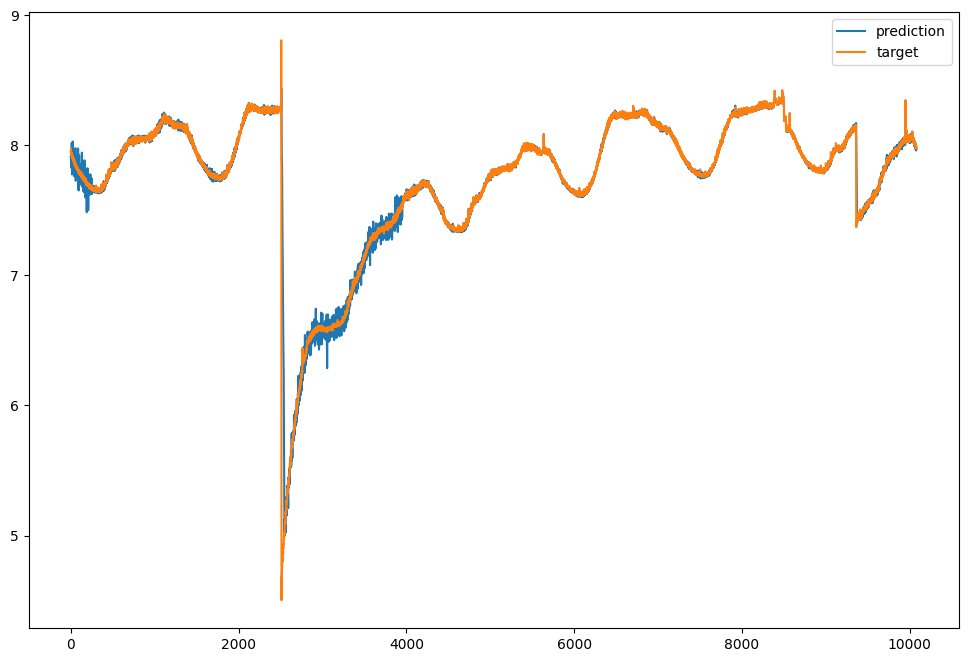

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [30]:
np.array(pred_list)

array([7.92196989, 7.89542246, 7.96912718, ..., 7.95954037, 7.98893833,
       7.98955965])

In [31]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[7.941656],
       [7.972712],
       [7.94328 ],
       ...,
       [7.980072],
       [7.974312],
       [7.976136]])

In [32]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [36]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

0.38793657440692186 %


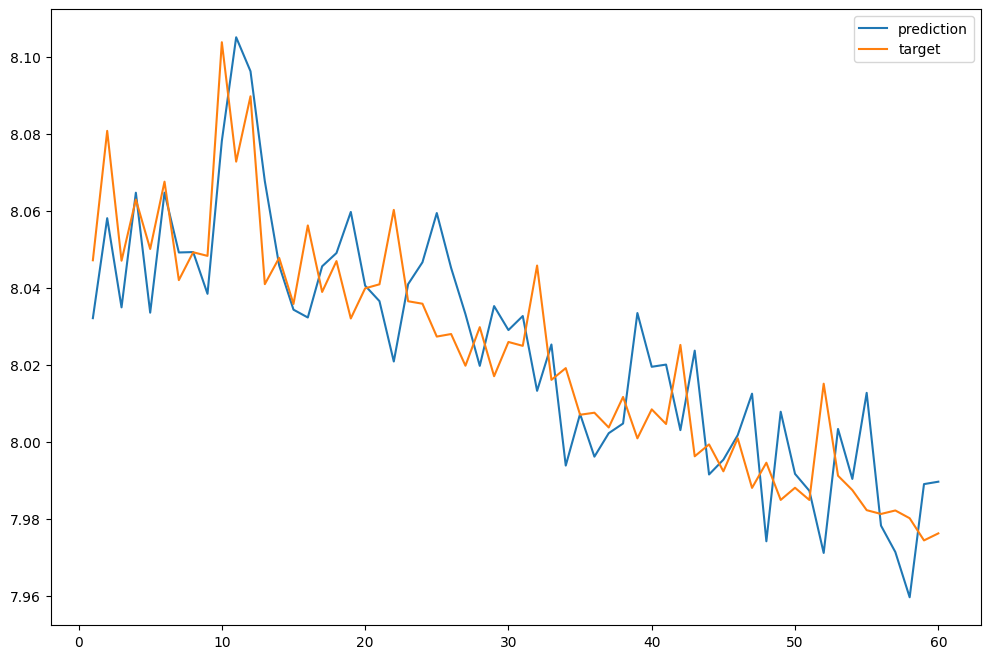

In [34]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [25]:
len(time_list)

10080

In [26]:
np.mean(time_list) 

0.3105386366683339

<font color = blue><font size = 6> Conclusion </font></font><br>
훈련을 하지 않았을때는 8퍼센트의 결과를 보였고 이해 비해서 0.3 퍼센트의 결과는 매우 좋은 결과이다 데이터의 의존성이 큰 DLinear,NLinear등은 이러한 결과가 변동성이 큰 데이터에서도 똑같이 적용될 것이라고 생각된다